In [1]:
# imports
from fishchips.experiments import CMB_Primary
from fishchips.cosmo import Observables
import fishchips.util

from classy import Class  # CLASS python wrapper
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# fonts and sizes
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [5.8,5.8]

In [11]:
import pickle
premades = pickle.load((open("../data/premades.p", "rb")) )
import copy

# copy the S3 lensing
planck_lensing = copy.deepcopy(premades['S3'][-1])

# the things that matter are k_min, k_max, f_sky, and noise_k
planck_lensing.k_min = 80
planck_lensing.k_max = 2500
planck_lensing.f_sky = 0.65
planck_lensing.noise_k = np.genfromtxt('/Users/juliexue/Desktop/fishchips/notebooks/planck_noise_k.txt', skip_footer=1)

In [2]:
# define classy as CL
CL = Class()

# function to get the spectra
def get_spectra(param):
    CL.set(param)
    CL.compute()
    fiducial_cls = CL.raw_cl(2500)
    return fiducial_cls

# set fiducial cosmology (Planck-2015) paramaters; see Appendix Table 2
# note: small o for omega refers to REDUCED parameter; omega_b = Omega_b*h^2
fid_param = {'omega_b':0.0222,
                   'omega_cdm':0.120,
                   'tau_reio':0.06,
                   'h':0.69,
                   'A_s':2.2e-09,
                   'n_s':0.966,
                   'output':'mPk,tCl,pCl,lCl,mPk',
                   'lensing':'nala'
                    }

In [38]:
# get the fiducial spectra
fid_spectra = get_spectra(fid_param)
#ll = fid_spectra['ell'][2:2081]
ll = fid_spectra['ell'][1:]
PP_curve = fid_spectra['pp'][2:2081]

# use for loop and zip to compute kappa-kappa C_ls
kk_curve = []

for x, y in zip(ll, PP_curve):
    kk_curve.append(1/4*y*(x-1)*x*(x+1)*(x+2))

#open four lensing noise files
f1 = open('/Users/juliexue/Desktop/fishchips/N_L_xcorr_noise_curve_act_dr6_lensing_map_v1.txt')
f2 = open('/Users/juliexue/Desktop/fishchips/notebooks/planck_noise_k.txt')
f3 = open('/Users/juliexue/Desktop/fishchips/notebooks/s3_noise_k.txt')
f4 = open('/Users/juliexue/Desktop/fishchips/notebooks/s4_noise_k.txt')
actdr6 = []
planck = []
s3 = []
s4 = []

for x in f1.readlines():
    actdr6.append(x.split()[1])
for x in f2.readlines():
    planck.append(x.split()[3])
for x in f3.readlines():
    s3.append(x.split()[3])
for x in f4.readlines():
    s4.append(x.split()[3])

In [16]:
# create an Observables object to store information for derivatives
pars = np.array( ['sigma_dmeff'])
centers = np.array([1e-25])
steps = np.array([1e-25])

obs = Observables(parameters=pars,
                  fiducial=centers,
                  left=centers-steps,
                  right=centers+steps)

# generate a template CLASS python wrapper configuration
classy_template = {'output': 'tCl pCl lCl',
                   'l_max_scalars': 2500,
                   'lensing': 'yes',
                   'omega_cdm':1e-15,
                   'omega_dmeff':0.120,
                   'npow_dmeff':0,
                   'Vrel_dmeff':0,
                   'dmeff_target': 'baryons',
                   'm_dmeff':1.,
                   'lensing': 'y' }

# add in the fiducial values too
classy_template.update(dict(zip(obs.parameters, obs.fiducial)))

# generate the fiducial cosmology
obs.compute_cosmo(key='fiducial', classy_dict=classy_template)

# generate an observables dictionary, looping over parameters
for par, par_left, par_right in zip(obs.parameters, obs.left, obs.right):
    classy_left = classy_template.copy()
    classy_left[par] = par_left
    classy_right = classy_template.copy()
    classy_right[par] = par_right
    # pass the dictionaries full of configurations to get computed
    obs.compute_cosmo(key=par + '_left', classy_dict=classy_left)
    obs.compute_cosmo(key=par + '_right', classy_dict=classy_right)

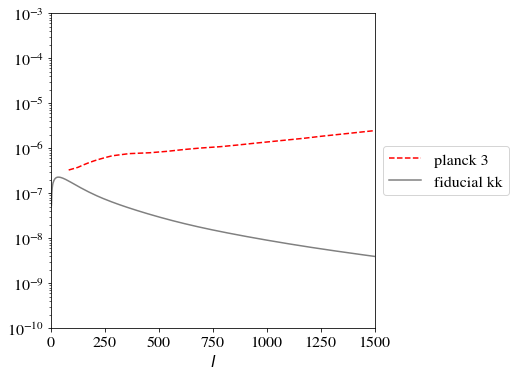

In [17]:
Planck_pp_noise = np.array(planck[1:2080:])
Planck_pp_noise = Planck_pp_noise.astype('float64')
Planck_pp_noise[Planck_pp_noise > 1e20] = np.nan
l_ranges = np.arange(len(Planck_pp_noise))
Planck_kk_noise = Planck_pp_noise*(l_ranges+1)*(l_ranges) /4
Planck_kk_noise = Planck_kk_noise.astype('float64')

# Reproduce Li Fig.2
plt.figure(1)
plt.xlim([0,1500])
plt.yscale('log')
plt.ylim([1e-10,1e-3])
plt.xlabel('$l$')
plt.plot(ll, Planck_kk_noise, color = 'red', linestyle = '--', label = 'planck 3')
plt.plot(ll, kk_curve, color = 'gray', linestyle = '-', label = 'fiducial kk')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [40]:
Planck_assumption = CMB_Primary(
    theta_fwhm=[14,10,7.,5.,5.], sigma_T=[137,65.,43.,66.,200], sigma_P=[450,103.,81.,134.,406],
    f_sky=0.6, l_min=2, l_max=2500)

information_planck = Planck_assumption.get_fisher_per_l(obs)
information_planck_TT = Planck_assumption.get_fisher_per_l_TT(obs)
# information_planck_kk = Planck_assumption.get_fisher_per_l_kk(obs=obs, kknoise=Planck_kk_noise)

# get the fiducial spectra (ACT DR6 version)
act_spectra = get_spectra(fid_param)
ll_act = fid_spectra['ell'][3:2081]
# ll_planck = np.arange(2500)
# sum together fisher matrices
fisher_pl_kk = np.sum( [exp.get_fisher_per_l(obs, lensed_Cl=True)
                  for exp in premades["Planck"]], axis=0 )
information_planck_kk = np.linalg.inv(fisher_pl_kk) # invert result to get covariance on parameters

# information contribution plot, Planck
plt.figure(1)
plt.xlim([0,2079])
plt.xlabel(r'$\ell$')
plt.ylabel(r'F per l')
plt.plot(ll, information_planck, color = 'blue', linestyle = '-', label = 'Planck TT/TE/EE')
plt.plot(ll, information_planck_TT, color = 'green', linestyle = '-', label = 'Planck TT')
plt.plot(ll, information_planck_kk, color = 'black', linestyle = '-', label = 'Planck TT/TE/EE/kk')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

/Users/juliexue/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: operands could not be broadcast together with shapes (30,) (100,) 

In [4]:
#test
planck_1_plot = np.array(planck_1[1:2080:])
planck_1_plot = planck_1_plot.astype('float64')
planck_2_plot = np.array(planck_2[1:2080:])
planck_2_plot = planck_2_plot.astype('float64')
planck_3_plot = np.array(planck_3[1:2080:])
planck_3_plot = planck_3_plot.astype('float64')
s3_1_plot = np.array(s3_1[1:2080:])
s3_1_plot = s3_1_plot.astype('float64')
s3_2_plot = np.array(s3_2[1:2080:])
s3_2_plot = s3_2_plot.astype('float64')
s3_3_plot = np.array(s3_3[1:2080:])
s3_3_plot = s3_3_plot.astype('float64')
s4_1_plot = np.array(s4_1[1:2080:])
s4_1_plot = s4_1_plot.astype('float64')
s4_2_plot = np.array(s4_2[1:2080:])
s4_2_plot = s4_2_plot.astype('float64')
s4_3_plot = np.array(s4_3[1:2080:])
s4_3_plot = s4_3_plot.astype('float64')

actdr6_kk_noise = np.array(actdr6[3:2082:])
actdr6_kk_noise = actdr6_kk_noise.astype('float64')

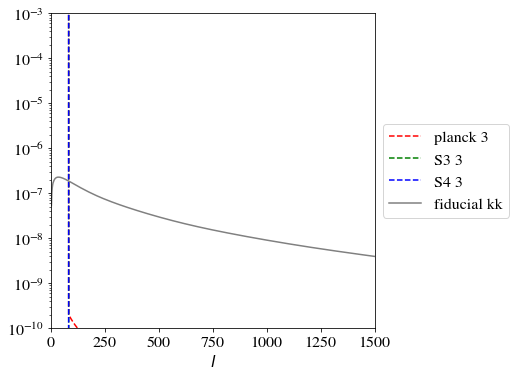

In [9]:
# Reproduce Li Fig.2
plt.figure(1)
plt.xlim([0,1500])
plt.yscale('log')
plt.ylim([1e-10,1e-3])
plt.xlabel('$l$')
plt.plot(ll, planck_3_plot, color = 'red', linestyle = '--', label = 'planck 3')
plt.plot(ll, s3_3_plot, color = 'green', linestyle = '--', label = 'S3 3')
plt.plot(ll, s4_3_plot, color = 'blue', linestyle = '--', label = 'S4 3')
plt.plot(ll, kk_curve, color = 'gray', linestyle = '-', label = 'fiducial kk')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

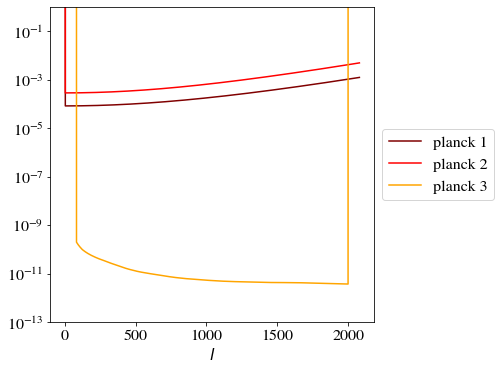

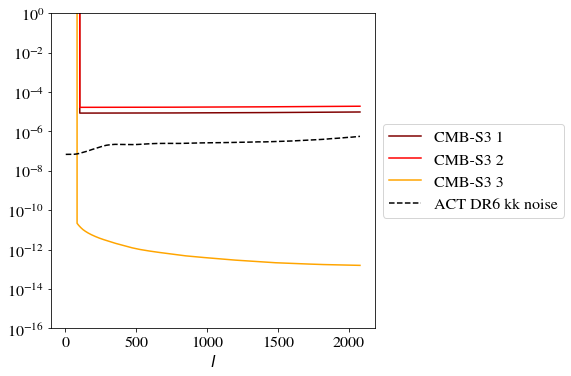

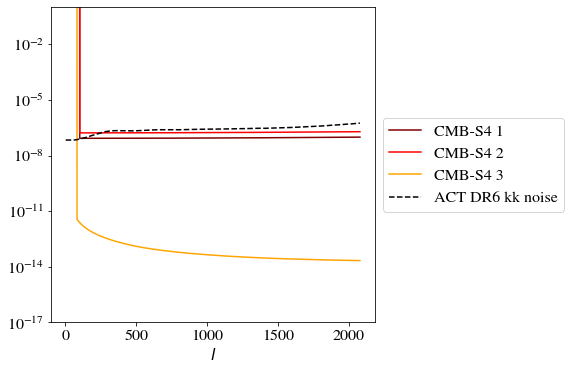

In [6]:
# Test plots for planck, s3, and s4
plt.figure(1)
#plt.xlim([0,2500])
plt.ylim([1e-13,1])
plt.yscale('log')
plt.xlabel('$l$')
plt.plot(ll, planck_1_plot, color = 'maroon', linestyle = '-', label = 'planck 1')
plt.plot(ll, planck_2_plot, color = 'red', linestyle = '-', label = 'planck 2')
plt.plot(ll, planck_3_plot, color = 'orange', linestyle = '-', label = 'planck 3')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.figure(2)
#plt.xlim([0,2500])
plt.ylim([1e-16,1])
plt.yscale('log')
plt.xlabel('$l$')
plt.plot(ll, s3_1_plot, color = 'maroon', linestyle = '-', label = 'CMB-S3 1')
plt.plot(ll, s3_2_plot, color = 'red', linestyle = '-', label = 'CMB-S3 2')
plt.plot(ll, s3_3_plot, color = 'orange', linestyle = '-', label = 'CMB-S3 3')
plt.plot(ll, actdr6_kk_noise, color = 'black', linestyle = '--', label = 'ACT DR6 kk noise')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.figure(3)
#plt.xlim([0,2500])
plt.ylim([1e-17,1])
plt.yscale('log')
plt.xlabel('$l$')
plt.plot(ll, s4_1_plot, color = 'maroon', linestyle = '-', label = 'CMB-S4 1')
plt.plot(ll, s4_2_plot, color = 'red', linestyle = '-', label = 'CMB-S4 2')
plt.plot(ll, s4_3_plot, color = 'orange', linestyle = '-', label = 'CMB-S4 3')
plt.plot(ll, actdr6_kk_noise, color = 'black', linestyle = '--', label = 'ACT DR6 kk noise')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [7]:
#planck_kk_noise = np.array(planck[1:2080:])
#planck_kk_noise = planck_kk_noise.astype('float64')
#s3_kk_noise = np.array(s3[1:2080:])
#s3_kk_noise = s3_kk_noise.astype('float64')
#s4_kk_noise = np.array(s4[1:2080:])
#s4_kk_noise = s4_kk_noise.astype('float64')
    
actdr6_kk_noise

array([6.79744798e-08, 6.79744798e-08, 6.79744798e-08, ...,
       5.57299645e-07, 5.57973851e-07, 5.58648056e-07])

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

In [9]:
CMB_S4 = CMB_Primary(
    theta_fwhm=[1.5], sigma_T=[1.], sigma_P=[1.],
    f_sky=0.4, l_min=2, l_max=2500)
ACT_or_S3 = CMB_Primary(
    theta_fwhm=[1.4], sigma_T=[10.], sigma_P=[10.],
    f_sky=0.4, l_min=2, l_max=2078)

act_or_s3 = ACT_or_S3.get_fisher_per_l(obs)
act_or_s3_TT = ACT_or_S3.get_fisher_per_l_TT(obs)
act_or_s3_kk = ACT_or_S3.get_fisher_per_l_kk(obs=obs, kknoise=actdr6_kk_noise)

NameError: name 'actdr6_kk_noise' is not defined

In [ ]:
#CMB-S4
#plt.figure(3)
#plt.xlim([0,2500])
#plt.ylim([0,2.5*1e50])
#plt.xlabel(r'$\ell$')
#plt.ylabel(r'F per l')
#plt.plot(l_numbers, information_S4, color = 'blue', linestyle = '-', label = 'CMB-S4 TT/TE/EE')
#plt.plot(l_numbers, information_S4_TT, color = 'green', linestyle = '-', label = 'CMB-S4 TT')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# ACT DR6
plt.figure(2)
plt.xlim([0,2080])
plt.xlabel(r'$\ell$')
plt.ylabel(r'F per l')
# plt.plot(ll_act, act_or_s3_kk, color = 'black', linestyle = '-', label = 'ACT DR6 TT/TE/EE/kk')
plt.plot(ll_act, act_or_s3, color = 'blue', linestyle = '-', label = 'CMB-S3 TT/TE/EE')
plt.plot(ll_act, act_or_s3_TT, color = 'green', linestyle = '-', label = 'CMB-S3 TT')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))